In [1]:
from shapely.geometry import Point 
from shapely.geometry import LineString
import pandas as pd
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import datetime
import numpy as np
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

# Adding CSV data

In [2]:
tornado_911 = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
cadd_tornado = pd.read_csv('../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv', skiprows = 3)
derecho_911 = pd.read_csv('../data/911_Phone Calls_Derecho_050320_050420.csv')
cadd_derecho = pd.read_csv('../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv', skiprows = 3)

# Fixing  CSV columns

In [3]:
tornado_911.columns = ['time', 'calltype', 'lat', 'lng', 'cell_tower_address']
derecho_911.columns = ['time', 'calltype', 'lat', 'lng', 'cell_tower_address']
cadd_tornado.columns = ['time', 'location', 'lat', 'lng', 'incident_type']
cadd_derecho.columns = ['time', 'location', 'lat', 'lng', 'incident_type']

In [4]:
tornado_911.time = pd.to_datetime(tornado_911.time)
derecho_911.time = pd.to_datetime(derecho_911.time)
cadd_tornado.time = pd.to_datetime(cadd_tornado.time)
cadd_derecho.time = pd.to_datetime(cadd_derecho.time)

In [5]:
tornado_911 = tornado_911.dropna(subset = ['lat', 'lng'])
derecho_911 = derecho_911.dropna(subset = ['lat', 'lng'])
cadd_tornado = cadd_tornado.dropna(subset = ['lat', 'lng'])
cadd_derecho = cadd_derecho.dropna(subset = ['lat', 'lng'])

In [6]:
tornado_911['geometry'] = tornado_911.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
derecho_911['geometry'] = derecho_911.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
cadd_tornado['geometry'] = cadd_tornado.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
cadd_derecho['geometry'] = cadd_derecho.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

# Adding geojson data

In [7]:
damage_points = gpd.read_file('../data/damage_points.geojson')
path_polygons = gpd.read_file('../data/path_polygons.geojson')
tornado_paths = gpd.read_file('../data/tornado_paths.geojson')

# Fixing geojson columns

In [8]:
damage_points.stormdate = damage_points.stormdate.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
damage_points.surveydate = damage_points.surveydate.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths.stormdate = tornado_paths.stormdate.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths.starttime = tornado_paths.starttime.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
tornado_paths.endtime = tornado_paths.endtime.apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))

# Making GeoDataFrames

In [9]:
geo_tornado_911 = gpd.GeoDataFrame(tornado_911, crs = tornado_paths.crs, geometry = tornado_911.geometry)
geo_derecho_911 = gpd.GeoDataFrame(derecho_911, crs = tornado_paths.crs, geometry = derecho_911.geometry)
geo_cadd_tornado = gpd.GeoDataFrame(cadd_tornado, crs = tornado_paths.crs, geometry = cadd_tornado.geometry)
geo_cadd_derecho = gpd.GeoDataFrame(cadd_derecho, crs = tornado_paths.crs, geometry = cadd_derecho.geometry)

# Filtering to the Nashville Tornado

In [10]:
nashville_tornado = tornado_paths.loc[tornado_paths.event_id == 'Nashville']
nashville_path = path_polygons.geometry.iloc[np.r_[4, 10:25, 26:35]]
nashville_path = nashville_path.reset_index()
nashville_path = nashville_path.drop(columns = ['index'])
nashville_damage = gpd.sjoin(damage_points, nashville_path, how = 'inner', op = 'within')
nashville_damage = nashville_damage.drop_duplicates(keep = 'first', subset = ['geometry'])

# Nashville Damage by Type

In [13]:
nashville_damage.head(10)

objectid           stormdate          surveydate      event_id  damage  \
0    2047717 2020-03-03 00:57:00 2020-03-04 09:28:00  Mount Juliet       2   
3    2060941 2020-03-03 00:43:00 2020-03-26 12:09:00                     1   
4    2060984 2020-03-03 00:43:00 2020-03-26 16:00:00                     7   
5    2090491 2020-03-03 00:44:00 2020-04-19 03:18:00                     1   
6    2098070 2020-03-03 00:52:00 2020-04-23 00:24:00                     1   
7    2100509 2020-03-03 00:54:00 2020-04-24 02:18:00                    27   
8    2048011 2020-03-03 01:04:00 2020-03-09 11:17:00       Lebanon       2   
9    2320477 2020-03-03 00:32:00 2021-04-17 18:29:00     Nashville      29   
10   2320478 2020-03-03 00:32:00 2021-04-17 18:32:00                    28   
11   2095724 2020-03-03 00:33:00 2020-04-22 09:21:00                    28   

                                   damage_txt  \
0        One- or Two-Family Residences (FR12)   
3      Small Barns or Farm Outbuildings (SBO)   
4   Masonry Apartment or Motel Building (MAM)   
5      Small Barns or Farm Outbuildings (SBO)   
6      Small Barns or Farm Outbuildings (SBO)   
7                        Trees: Hardwood (TH)   
8        One- or Two-Family Residences (FR12)   
9                                   Other (O)   
10                       Trees: Softwood (TS)   
11                       Trees: Softwood (TS)   

                              dod_txt efscale damage_dir windspeed  ...  qc  \
0                 All walls collapsed     EF3        N/A       155  ...   Y   
3       Total destruction of building     EF1        N/A        95  ...   Y   
4        Loss of roof covering (<20%)     EF0        N/A        80  ...   Y   
5       Total destruction of building     EF1        N/A       105  ...   Y   
6   Loss of wood or metal roof panels     EF0        N/A        85  ...   Y   
7                      Trunks snapped     EF1        N/A       110  ...   Y   
8            Exterior walls collapsed     EF2        N/A       120  ...   Y   
9                        Other damage     EF0        N/A        70  ...   Y   
10                     Trees uprooted     EF0      NE/45        75  ...   Y   
11                     Trees uprooted     EF0        N/A        75  ...   Y   

    dod  surveytype                                globalid  \
0     9        None  {FE82BBAC-ABF8-4562-81F6-A527829FBFFE}   
3     8        None  {A0744CB4-5993-4056-A13C-CF75182F5147}   
4     2        None  {DA83D428-084A-4ACA-A39E-DEE84AA28463}   
5     8        None  {F885805B-9BD4-448C-9855-CC2D5425AC43}   
6     2        None  {18B795BC-211B-4B14-A8F5-2A68167D6B25}   
7     4        None  {277F1AF5-ACAC-4D97-BC5E-AA5CFCDECEB7}   
8     7        None  {328BF9CD-DA7D-4A30-B5D3-BA6123F9E0EB}   
9     1        None  {5071191E-4409-4F75-BD83-BE52ED30723C}   
10    3        None  {C98C07B7-FF29-4D91-9B88-35D7F1C07D1C}   
11    3        None  {8E0A33E9-9EED-4266-9142-8A6B75819871}   

              edit_user edit_time  \
0                  None      None   
3                  None      None   
4                  None      None   
5                  None      None   
6                  None      None   
7                  None      None   
8                  None      None   
9                  None      None   
10                 None      None   
11  Sam.Shamburger_noaa      None   

                                             comments path_guid  \
0                                                none      None   
3                                                None      None   
4                                                None      None   
5                                                None      None   
6                                                None      None   
7                                                None      None   
8                                                none      None   
9   Boathouse and dock blown northward and heavily...      None   
10                  Tree blown

In [14]:
nashville_damage.stormdate.max()

Timestamp('2020-03-03 01:34:00')

# Ploting out Nashville damage data

### Creating GeoDataFrames to map out data

In [15]:
Other = damage_points.loc[damage_points.damage_txt == 'Other (O)']

Trees = damage_points.loc[(damage_points.damage_txt == 'Trees: Hardwood (TH)')
                         |(damage_points.damage_txt == 'Trees: Softwood (TS)')]

Residential = damage_points.loc[(damage_points.damage_txt == 'One- or Two-Family Residences (FR12)')
                               |(damage_points.damage_txt == 'Masonry Apartment or Motel Building (MAM)')
                               |(damage_points.damage_txt == 'Manufactured Home - Single Wide (MHSW)')
                               |(damage_points.damage_txt == 'Apartments, Condos, Townhouses [3 stories or less] (ACT)')
                               |(damage_points.damage_txt == 'Manufactured Home - Double Wide (MHDW)')
                               |(damage_points.damage_txt == 'Motel (M)')]

Commercial = damage_points.loc[(damage_points.damage_txt == 'Small Barns or Farm Outbuildings (SBO)')
                              |(damage_points.damage_txt == 'Metal Building System (MBS)')
                              |(damage_points.damage_txt == 'Low-Rise Building [1-4 Stories] (LRB)')
                              |(damage_points.damage_txt == 'Electrical Transmission Lines (ETL)')
                              |(damage_points.damage_txt == 'Small Professional Building [Doctors Office, Branch Banks] (SPB)')
                              |(damage_points.damage_txt == 'Institutional Building [Hospital, Government or University Building] (IB)')
                              |(damage_points.damage_txt == 'Large, Isolated Retail Building [K-Mart, Wal-Mart] (LIRB)')                    
                              |(damage_points.damage_txt == 'Junior or Senior High School (JHSH)')                      
                              |(damage_points.damage_txt == 'Strip Mall (SM)') 
                              |(damage_points.damage_txt == 'Elementary School [Single Story; Interior or Exterior Hallways] (ES)') 
                              |(damage_points.damage_txt == 'Mid-Rise Building [5-20 Stories] (MRB)')  
                              |(damage_points.damage_txt == 'Free-Standing Towers (FST)' )
                              |(damage_points.damage_txt == 'Service Station Canopy (SSC)') 
                              |(damage_points.damage_txt == 'Small Retail Building [Fast Food Restaurants] (SRB)')]

### Creating dataframe for damage_txt 

In [16]:
nash_damage = nashville_damage.damage_txt.value_counts()

In [17]:
nash_damage = nash_damage.to_frame()

In [18]:
type(nash_damage)

pandas.core.frame.DataFrame

In [19]:
nash_damage.columns

Index(['damage_txt'], dtype='object')

In [20]:
nash_damage = nash_damage.reset_index()
nash_damage

index  damage_txt
0                One- or Two-Family Residences (FR12)        2165
1              Small Barns or Farm Outbuildings (SBO)         288
2   Apartments, Condos, Townhouses [3 stories or l...          65
3                         Metal Building System (MBS)          63
4                                Trees: Hardwood (TH)          61
5   Warehouse Building [Tilt-up Walls or Heavy-Tim...          40
6               Low-Rise Building [1-4 Stories] (LRB)          34
7   Small Retail Building [Fast Food Restaurants] ...          31
8   Small Professional Building [Doctor's Office, ...          28
9   Institutional Building [Hospital, Government o...          25
10             Manufactured Home - Single Wide (MHSW)          25
11                               Trees: Softwood (TS)          21
12                Electrical Transmission Lines (ETL)          18
13  Elementary School [Single Story; Interior or E...          10
14                                    Strip Mall (SM)           9
15             Manufactured Home - Double Wide (MHDW)           8
16                                          Other (O)           7
17                                          Motel (M)           6
18          Masonry Apartment or Motel Building (MAM)           5
19             Mid-Rise Building [5-20 Stories] (MRB)           4
20  Large, Isolated Retail Building [K-Mart, Wal-M...           3
21                Junior or Senior High School (JHSH)           3
22                  Automobile Service Building (ASB)           3
23                       Service Station Canopy (SSC)           3
24                         Free-Standing Towers (FST)           1

In [21]:
counts = nash_damage.reset_index(drop = True)

In [22]:
counts.columns = ['damage_type', 'count']

### Plotting the damage_txt

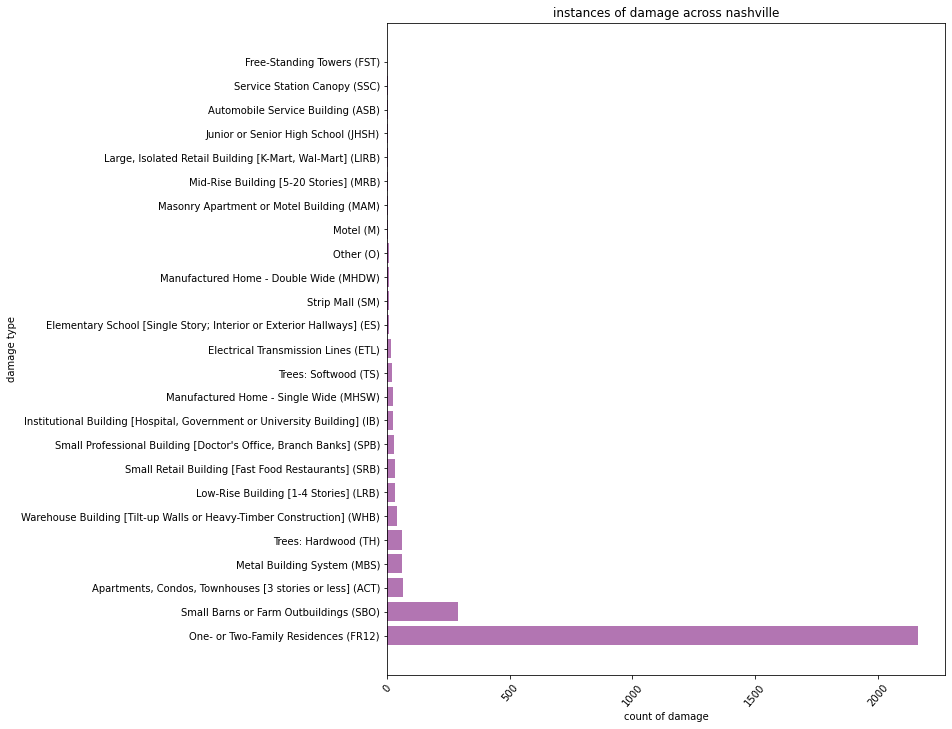

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize = (10,12))
plt.barh('damage_type', 'count', data = counts, color = (0.5,0.1,0.5,0.6))

plt.xticks(rotation = 50)
plt.xlabel('count of damage')
plt.ylabel('damage type')
plt.title('instances of damage across nashville')
plt.show()

plt.savefig("../plots/dmg_specific.png")

### Creating dataframe for the categorized types of damage data

In [24]:
for index, damage_txt in enumerate(damage_points['damage_txt']):
    if damage_txt in ['Small Barns or Farm Outbuildings (SBO)', 'Metal Building System (MBS)',
                     'Low-Rise Building [1-4 Stories] (LRB)', 'Electrical Transmission Lines (ETL)',
                     'Small Professional Building [Doctors Office, Branch Banks] (SPB)',
                     'Institutional Building [Hospital, Government or University Building] (IB)',
                     'Large, Isolated Retail Building [K-Mart, Wal-Mart] (LIRB)',
                     'Junior or Senior High School (JHSH)', 'Strip Mall (SM)',
                     'Warehouse Building [Tilt-up Walls or Heavy-Timber Construction] (WHB)',
                     'Elementary School [Single Story; Interior or Exterior Hallways] (ES)',
                     'Free-Standing Towers (FST)', 'Service Station Canopy (SSC)',
                     'Mid-Rise Building [5-20 Stories] (MRB)']:
        damage_points.loc[index, 'category'] = 'Commercial'
        
    elif damage_txt in ['One- or Two-Family Residences (FR12)', 'Masonry Apartment or Motel Building (MAM)',
                       'Manufactured Home - Single Wide (MHSW)', 'Apartments, Condos, Townhouses [3 stories or less] (ACT)',
                       'Manufactured Home - Double Wide (MHDW)', 'Motel (M)']:
        damage_points.loc[index, 'category'] = 'Residential'
        
    elif damage_txt in ['Trees: Hardwood (TH)', 'Trees: Softwood (TS)']:
        damage_points.loc[index, 'category'] = 'Trees'
        
    elif damage_txt in ['Other (O)']:
        damage_points.loc[index, 'category'] = 'Other'

In [25]:
category_damage = damage_points.category.value_counts()

In [26]:
category_damage = category_damage.to_frame()

In [27]:
category_damage = category_damage.reset_index()
category_damage

index  category
0  Residential      2997
1   Commercial       644
2        Trees       241
3        Other         9

In [28]:
cat_counts = category_damage.reset_index(drop = True)

In [29]:
cat_counts.columns = ['category', 'count']

### Plotting Categorized damage_txt data

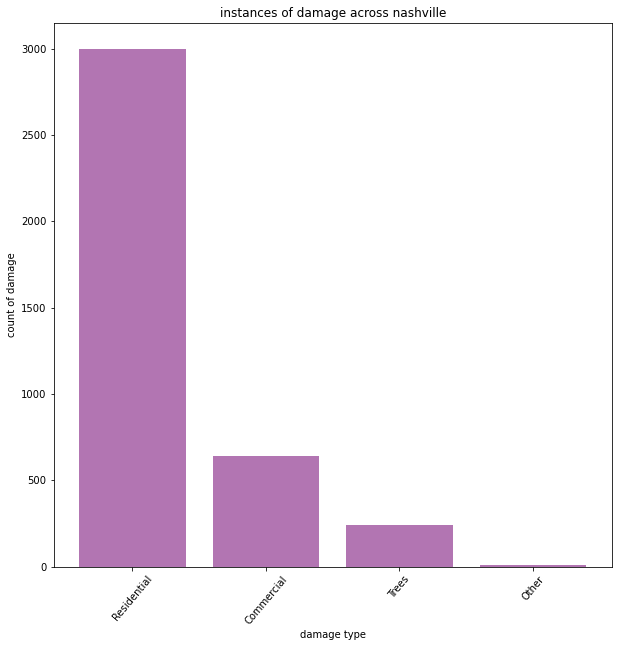

<Figure size 432x288 with 0 Axes>

In [31]:
plt.figure(figsize = (10,10))
plt.bar('category', 'count', data = cat_counts, color = (0.5,0.1,0.5,0.6))

plt.xticks(rotation = 50)
plt.xlabel('damage type')
plt.ylabel('count of damage')
plt.title('instances of damage across nashville')
plt.show()

plt.savefig("../plots/dmg_category.png")

# Mapping the Nashville tornado damage

### Mapping Tree and unknown structure data

In [100]:
style = {'fillColor': 'red', 'color': 'red'}
style2 = {'fillColor': 'lightgreen', 'color': 'lightgreen'}
startloc = [36.1627, -86.7816]

#mapping tornado path

map_damage = folium.Map(location = startloc, zoom_start = 12)

folium.GeoJson(nashville_tornado.geometry, style_function = lambda x:style).add_to(map_damage)
folium.GeoJson(nashville_path.geometry, style_function = lambda x:style2).add_to(map_damage)
   
#mapping tree damage points
    
for row_index, row_values in Trees.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = [row_values['dod_txt']]
    icon = folium.Icon(color = 'green', icon = 'tree', prefix = 'fa')
    marker = folium.Marker(location = loc, popup = pop, icon = icon)
    marker.add_to(map_damage)

#mapping other/unknown damage points
    
for row_index, row_values in Other.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = [row_values['dod_txt']]
    icon = folium.Icon(color = 'gray', icon = 'question-circle', prefix = 'fa')
    marker = folium.Marker(location = loc, popup = pop, icon = icon)
    marker.add_to(map_damage)

map_damage.save('../maps/trees_map_damage.html')    
map_damage

### Mapping Residential data

In [104]:
style = {'fillColor': 'red', 'color': 'red'}
style2 = {'fillColor': 'lightgreen', 'color': 'lightgreen'}
startloc = [36.1627, -86.7816]

#mapping tornado path

map_damage = folium.Map(location = startloc, zoom_start = 12)

folium.GeoJson(nashville_tornado.geometry, style_function = lambda x:style).add_to(map_damage)
folium.GeoJson(nashville_path.geometry, style_function = lambda x:style2).add_to(map_damage)

#mapping residential damage points

for row_index, row_values in Residential.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = [row_values['dod_txt']]
    icon = folium.Icon(color = 'red', icon = 'home', prefix = 'fa')
    marker = folium.Marker(location = loc, popup = pop, icon = icon)
    marker.add_to(map_damage)
    
map_damage.save('../maps/residential_map_damage.html')    
map_damage

In [20]:
### Mapping Commercial data

In [102]:
style = {'fillColor': 'red', 'color': 'red'}
style2 = {'fillColor': 'lightgreen', 'color': 'lightgreen'}
startloc = [36.1627, -86.7816]

#mapping tornado path

map_damage = folium.Map(location = startloc, zoom_start = 12)

folium.GeoJson(nashville_tornado.geometry, style_function = lambda x:style).add_to(map_damage)
folium.GeoJson(nashville_path.geometry, style_function = lambda x:style2).add_to(map_damage)

# #mapping commercial damage points    
    
for row_index, row_values in Commercial.iterrows():
    loc = [row_values['lat'], row_values['lon']]
    pop = [row_values['dod_txt']]
    icon = folium.Icon(color = 'blue', icon = 'building', prefix = 'fa')
    marker = folium.Marker(location = loc, popup = pop, icon = icon)
    marker.add_to(map_damage)
    
map_damage.save('../maps/commercial_map_damage.html')    
map_damage